# Different Configuration using Homeostasis with Kmeans

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import os
from HOTS.Monitor import GenerateAM, DisplayAM
from HOTS.Event import Event, SimpleAlphabet
from HOTS.STS import STS
from HOTS.Layer import ClusteringLayer, FilterNHBD
from HOTS.Monitor import (
    DisplayImage,
    DisplaySurface3D,
    DisplaySurface2D,
    DisplayConvergence,
)
from HOTS.Tools import SaveObject, LoadObject
from HOTS.Classifier import Classifier
from HOTS.Network import Network
from HOTS.KmeansHomeoCluster import KmeansHomeo

# 1. Defining Common parameter

In [3]:
tau = 0.02
R = 2
nb_cluster = [4, 8, 16]
eta_list = [1e-5, 1e-5, 1e-5]
eta_homeo_list = [1e-3, 1e-3, 1e-3]
C_list = [6, 18, 40]
ImageSize = (32, 32)
DataPath = "../Data/ExtractedStabilized.mat"
LabelPath = "../Data/alphabet_label.pkl"

# 2. StepbyStep Training

In [4]:
"""
image_list = [1, 32, 19, 22, 29]
event0 = Event(ImageSize=(32,32),OutOnePolarity=False)

event0.LoadFromMat('../Data/ExtractedStabilized.mat',image_number=image_list)

## Layer1

    SpTe_Layer1= STS(tau=tau, R=R,verbose=0)
Surface_Layer1 = SpTe_Layer1.create(event = event0,kernel='linear')

ClusterLayer1 = KmeansHomeo(nb_cluster = nb_cluster[0], eta=eta_list[0], eta_homeo=eta_homeo_list[0],
                            C=C_list[0], to_record=True, verbose=0)
Prototype1 = ClusterLayer1.fit(SpTe_Layer1,NbCycle=3,record_num_batches=10000)
event2,_ = ClusterLayer1.predict(Surface=SpTe_Layer1.Surface,event = event0)
## Layer2
SpTe_Layer2= STS(tau=10*tau, R=2*R,verbose=0)
Surface_Layer2 = SpTe_Layer2.create(event = event2,kernel='linear')
ClusterLayer2 = KmeansHomeo(nb_cluster = nb_cluster[1], eta=eta_list[1], eta_homeo=eta_homeo_list[1],
                            C=C_list[1],to_record=True, verbose=0)
Prototype2 = ClusterLayer2.fit(SpTe_Layer2,NbCycle=3,record_num_batches=10000)
event3,_ = ClusterLayer2.predict(Surface=SpTe_Layer2.Surface,event = event2)

## Layer3
SpTe_Layer3= STS(tau=10*10*tau, R=2*2*R,verbose=0)
Surface_Layer3 = SpTe_Layer3.create(event = event3,kernel='linear')
ClusterLayer3 = KmeansHomeo(nb_cluster = nb_cluster[2], eta=eta_list[2], eta_homeo=eta_homeo_list[2],
                            C=C_list[2],to_record=True, verbose=0)
Prototype3 = ClusterLayer3.fit(SpTe_Layer3,NbCycle=3,record_num_batches=10000)
event4,_ = ClusterLayer3.predict(Surface=SpTe_Layer3.Surface,event = event3)
"""

"\nimage_list = [1, 32, 19, 22, 29]\nevent0 = Event(ImageSize=(32,32),OutOnePolarity=False)\n\nevent0.LoadFromMat('../Data/ExtractedStabilized.mat',image_number=image_list)\n\n## Layer1\n\n    SpTe_Layer1= STS(tau=tau, R=R,verbose=0)\nSurface_Layer1 = SpTe_Layer1.create(event = event0,kernel='linear')\n\nClusterLayer1 = KmeansHomeo(nb_cluster = nb_cluster[0], eta=eta_list[0], eta_homeo=eta_homeo_list[0],\n                            C=C_list[0], to_record=True, verbose=0)\nPrototype1 = ClusterLayer1.fit(SpTe_Layer1,NbCycle=3,record_num_batches=10000)\nevent2,_ = ClusterLayer1.predict(Surface=SpTe_Layer1.Surface,event = event0)\n## Layer2\nSpTe_Layer2= STS(tau=10*tau, R=2*R,verbose=0)\nSurface_Layer2 = SpTe_Layer2.create(event = event2,kernel='linear')\nClusterLayer2 = KmeansHomeo(nb_cluster = nb_cluster[1], eta=eta_list[1], eta_homeo=eta_homeo_list[1],\n                            C=C_list[1],to_record=True, verbose=0)\nPrototype2 = ClusterLayer2.fit(SpTe_Layer2,NbCycle=3,record_num_ba

In [5]:
# DisplaySurface2D(ClusterLayer1.prototype,nb_polarities=2)
# DisplaySurface2D(ClusterLayer2.prototype, nb_polarities=4)
# DisplaySurface2D(ClusterLayer3.prototype, nb_polarities=8)
# DisplayConvergence([ClusterLayer1,ClusterLayer2,ClusterLayer3],to_display=['error','histo'])

# 3. Experiment with one polarity in input  

## 3.1. Exp1 :  Homeo Kmeans + Linear Kernel +  NoiseFilter(=2)  +  1 Polarity in Input + 3 Cycles

In [6]:
event_tr, event_te, event_cl, label_tr, label_te = SimpleAlphabet(
    NbTrainingData=36,
    NbTestingData=40,
    Path=DataPath,
    LabelPath=LabelPath,
    ClusteringData=[1, 32, 19, 22, 29],
    OutOnePolarity=True,
    verbose=0,
)
## Defining the network
L1 = ClusteringLayer(
    tau=tau,
    R=R,
    verbose=0,
    ThrFilter=2,
    LearningAlgo="homeo",
    kernel="linear",
    eta=eta_list[0],
    eta_homeo=eta_homeo_list[0],
    C=C_list[0],
)
L2 = ClusteringLayer(
    tau=10 * tau,
    R=2 * R,
    verbose=0,
    ThrFilter=2,
    LearningAlgo="homeo",
    kernel="linear",
    eta=eta_list[1],
    eta_homeo=eta_homeo_list[1],
    C=C_list[1],
)
L3 = ClusteringLayer(
    tau=10 * 10 * tau,
    R=2 * 2 * R,
    verbose=0,
    ThrFilter=2,
    LearningAlgo="homeo",
    kernel="linear",
    eta=eta_list[2],
    eta_homeo=eta_homeo_list[2],
    C=C_list[2],
)
Net = Network([L1, L2, L3])

fname = "../Records/EXP_03_HomeoKmeans/Exp01_2020-04-17.pkl"
if not os.path.isfile(fname):
    #### Training The Cluster on 5 images
    ClusterLayer, event_output = Net.TrainCluster(
        event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=3
    )
    ## Generating histogram for training samples
    event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer)
    ## Generating histogram for the test samples
    event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer)
    Classif0 = Classifier(
        event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
    )
    SaveObject([ClusterLayer, Classif0], fname)
else:
    ClusterLayer, Classif0 = LoadObject(fname)
prediction, accuracy, method = Classif0.HistogramDistance(to_print=True)

battacha:97.5% ### normalized:95.0% ### euclidian:97.5% ### 


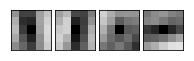

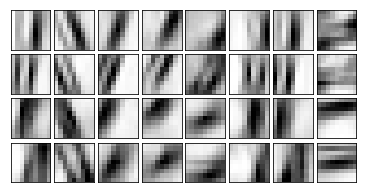

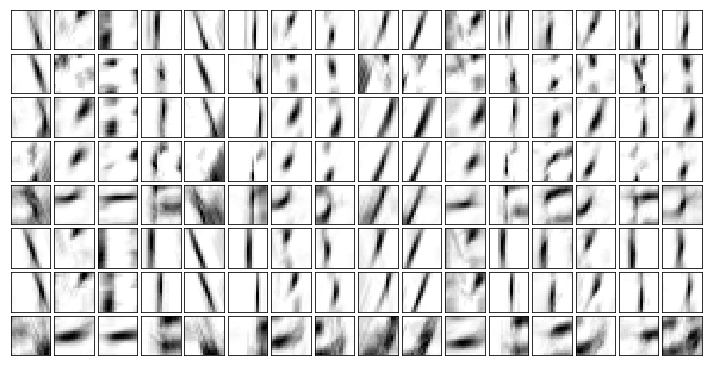

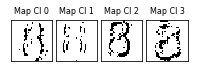

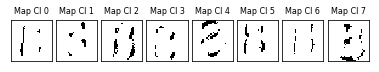

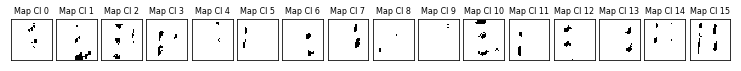

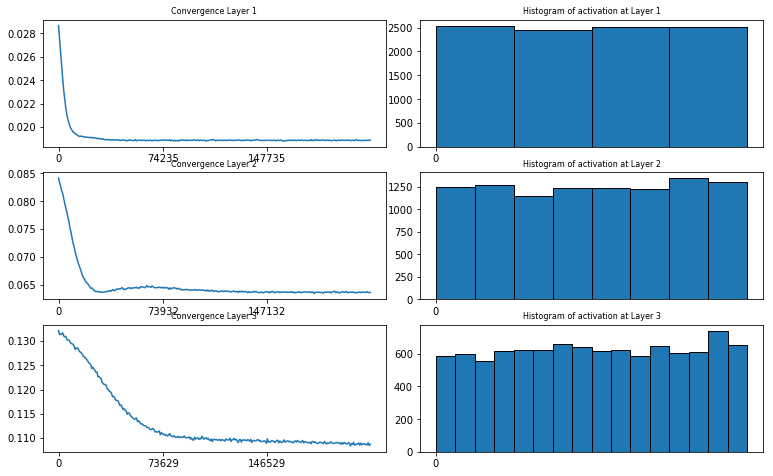

In [7]:
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=1)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
event_to_show = Event(ImageSize=(32, 32), ListPolarities=[-1, 1], OutOnePolarity=True)
event_to_show.LoadFromMat("../Data/ExtractedStabilized.mat", image_number=22)
Net.RunNetwork(event_to_show, NbClusterList=ClusterLayer)
mapL1 = GenerateAM(Net.Layers[0].output, ClusterLayer[0])
DisplayAM(mapL1, scale=2)
mapL2 = GenerateAM(Net.Layers[1].output, ClusterLayer[1])
DisplayAM(mapL2, scale=2)
mapL3 = GenerateAM(Net.Layers[2].output, ClusterLayer[2])
DisplayAM(mapL3, scale=2)

DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

## 3.2. Exp2 : Homeo Kmeans + Exp Kernel + NoiseFilter(=2) +  1 Polarity in Input + 3 Cycles

In [8]:
event_tr, event_te, event_cl, label_tr, label_te = SimpleAlphabet(
    NbTrainingData=36,
    NbTestingData=40,
    Path=DataPath,
    LabelPath=LabelPath,
    ClusteringData=[1, 32, 19, 22, 29],
    OutOnePolarity=True,
    verbose=0,
)
## Defining the network
L1 = ClusteringLayer(
    tau=tau,
    R=R,
    verbose=0,
    ThrFilter=2,
    LearningAlgo="homeo",
    kernel="exponential",
    eta=eta_list[0],
    eta_homeo=eta_homeo_list[0],
    C=C_list[0],
)
L2 = ClusteringLayer(
    tau=10 * tau,
    R=2 * R,
    verbose=0,
    ThrFilter=2,
    LearningAlgo="homeo",
    kernel="exponential",
    eta=eta_list[1],
    eta_homeo=eta_homeo_list[1],
    C=C_list[1],
)
L3 = ClusteringLayer(
    tau=10 * 10 * tau,
    R=2 * 2 * R,
    verbose=0,
    ThrFilter=2,
    LearningAlgo="homeo",
    kernel="exponential",
    eta=eta_list[2],
    eta_homeo=eta_homeo_list[2],
    C=C_list[2],
)
Net = Network([L1, L2, L3])

fname = "../Records/EXP_03_HomeoKmeans/Exp02_2020-04-17.pkl"
if not os.path.isfile(fname):
    #### Training The Cluster on 5 images
    ClusterLayer, event_output = Net.TrainCluster(
        event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=3
    )
    ## Generating histogram for training samples
    event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer)
    ## Generating histogram for the test samples
    event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer)
    Classif0 = Classifier(
        event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
    )
    SaveObject([ClusterLayer, Classif0], fname)
else:
    ClusterLayer, Classif0 = LoadObject(fname)
prediction, accuracy, method = Classif0.HistogramDistance(to_print=True)

battacha:90.0% ### normalized:87.5% ### euclidian:90.0% ### 


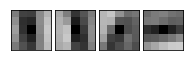

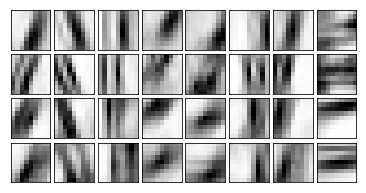

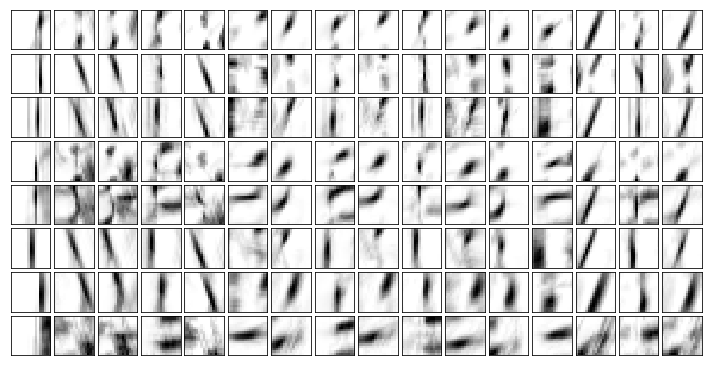

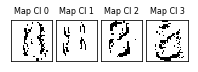

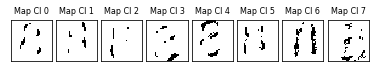

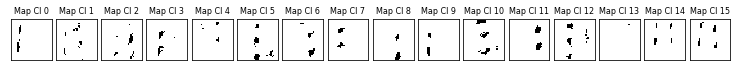

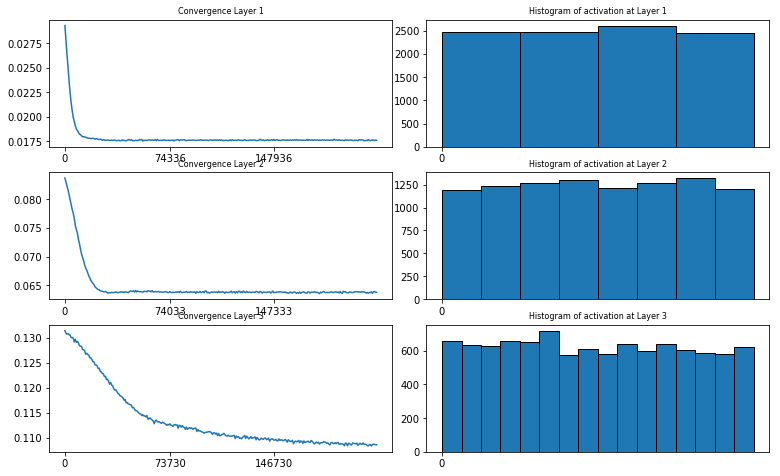

In [9]:
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=1)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
event_to_show = Event(ImageSize=(32, 32), ListPolarities=[-1, 1], OutOnePolarity=True)
event_to_show.LoadFromMat("../Data/ExtractedStabilized.mat", image_number=22)
Net.RunNetwork(event_to_show, NbClusterList=ClusterLayer)
mapL1 = GenerateAM(Net.Layers[0].output, ClusterLayer[0])
DisplayAM(mapL1, scale=2)
mapL2 = GenerateAM(Net.Layers[1].output, ClusterLayer[1])
DisplayAM(mapL2, scale=2)
mapL3 = GenerateAM(Net.Layers[2].output, ClusterLayer[2])
DisplayAM(mapL3, scale=2)

DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

# 4. Experiment with 2 polarities in Input 

## 4.1. Exp3 : Homeo Kmeans + Linear Kernel + NoiseFilter(=2) + 2 Polarity in Input + 3 Cycles

In [10]:
event_tr, event_te, event_cl, label_tr, label_te = SimpleAlphabet(
    NbTrainingData=36,
    NbTestingData=40,
    Path=DataPath,
    LabelPath=LabelPath,
    ClusteringData=[1, 32, 19, 22, 29],
    OutOnePolarity=False,
    verbose=0,
)
## Defining the network
L1 = ClusteringLayer(
    tau=tau,
    R=R,
    verbose=0,
    ThrFilter=2,
    LearningAlgo="homeo",
    kernel="linear",
    eta=eta_list[0],
    eta_homeo=eta_homeo_list[0],
    C=C_list[0],
)
L2 = ClusteringLayer(
    tau=10 * tau,
    R=2 * R,
    verbose=0,
    ThrFilter=2,
    LearningAlgo="homeo",
    kernel="linear",
    eta=eta_list[1],
    eta_homeo=eta_homeo_list[1],
    C=C_list[1],
)
L3 = ClusteringLayer(
    tau=10 * 10 * tau,
    R=2 * 2 * R,
    verbose=0,
    ThrFilter=2,
    LearningAlgo="homeo",
    kernel="linear",
    eta=eta_list[2],
    eta_homeo=eta_homeo_list[2],
    C=C_list[2],
)
Net = Network([L1, L2, L3])

fname = "../Records/EXP_03_HomeoKmeans/Exp03_2020-04-17.pkl"
if not os.path.isfile(fname):
    #### Training The Cluster on 5 images
    ClusterLayer, event_output = Net.TrainCluster(
        event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=3
    )
    ## Generating histogram for training samples
    event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer)
    ## Generating histogram for the test samples
    event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer)
    Classif0 = Classifier(
        event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
    )
    SaveObject([ClusterLayer, Classif0], fname)
else:
    ClusterLayer, Classif0 = LoadObject(fname)
prediction, accuracy, method = Classif0.HistogramDistance(to_print=True)

battacha:97.5% ### normalized:97.5% ### euclidian:97.5% ### 


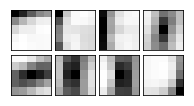

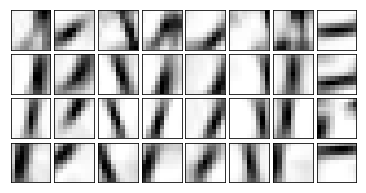

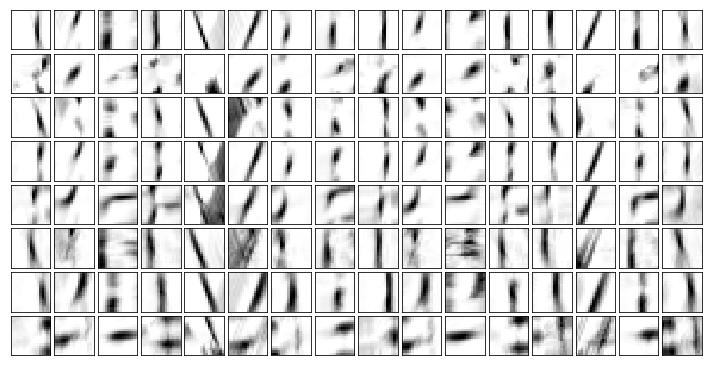

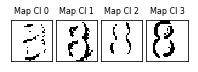

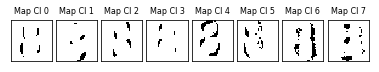

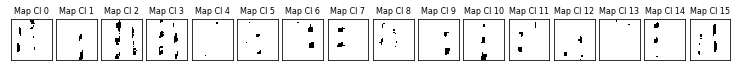

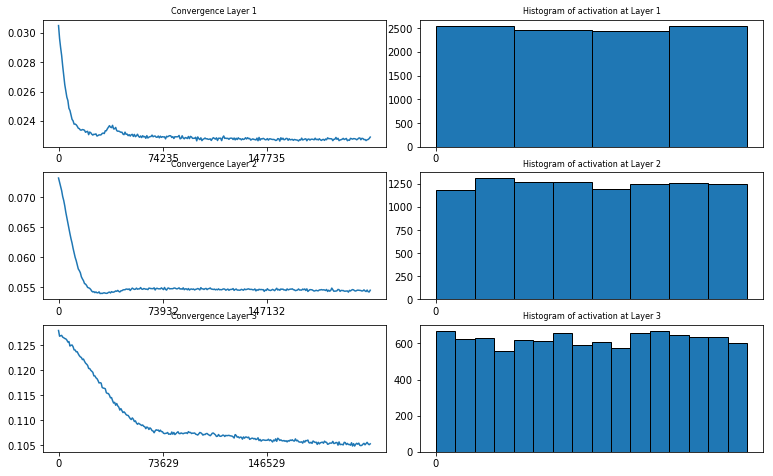

In [11]:
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
event_to_show = Event(ImageSize=(32, 32), ListPolarities=[-1, 1], OutOnePolarity=False)
event_to_show.LoadFromMat("../Data/ExtractedStabilized.mat", image_number=22)
Net.RunNetwork(event_to_show, NbClusterList=ClusterLayer)
mapL1 = GenerateAM(Net.Layers[0].output, ClusterLayer[0])
DisplayAM(mapL1, scale=2)
mapL2 = GenerateAM(Net.Layers[1].output, ClusterLayer[1])
DisplayAM(mapL2, scale=2)
mapL3 = GenerateAM(Net.Layers[2].output, ClusterLayer[2])
DisplayAM(mapL3, scale=2)

DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

## 4.2 Exp4 : Maro Kmeans + Exp Kernel + NoiseFilter(=2) + 2 Polarity in Input + 3 Cycles

In [12]:
save_exp = False
event_tr, event_te, event_cl, label_tr, label_te = SimpleAlphabet(
    NbTrainingData=36,
    NbTestingData=40,
    Path=DataPath,
    LabelPath=LabelPath,
    ClusteringData=[1, 32, 19, 22, 29],
    OutOnePolarity=False,
    verbose=0,
)
## Defining the network
L1 = ClusteringLayer(
    tau=tau,
    R=R,
    verbose=0,
    ThrFilter=2,
    LearningAlgo="homeo",
    kernel="exponential",
    eta=eta_list[0],
    eta_homeo=eta_homeo_list[0],
    C=C_list[0],
)
L2 = ClusteringLayer(
    tau=10 * tau,
    R=2 * R,
    verbose=0,
    ThrFilter=2,
    LearningAlgo="homeo",
    kernel="exponential",
    eta=eta_list[1],
    eta_homeo=eta_homeo_list[1],
    C=C_list[1],
)
L3 = ClusteringLayer(
    tau=10 * 10 * tau,
    R=2 * 2 * R,
    verbose=0,
    ThrFilter=2,
    LearningAlgo="homeo",
    kernel="exponential",
    eta=eta_list[2],
    eta_homeo=eta_homeo_list[2],
    C=C_list[2],
)
Net = Network([L1, L2, L3])

fname = "../Records/EXP_03_HomeoKmeans/Exp04_2020-04-17.pkl"
if not os.path.isfile(fname):
    #### Training The Cluster on 5 images
    ClusterLayer, event_output = Net.TrainCluster(
        event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=3
    )
    ## Generating histogram for training samples
    event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer)
    ## Generating histogram for the test samples
    event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer)
    Classif0 = Classifier(
        event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
    )
    SaveObject([ClusterLayer, Classif0], fname)
else:
    ClusterLayer, Classif0 = LoadObject(fname)
prediction, accuracy, method = Classif0.HistogramDistance(to_print=True)

battacha:90.0% ### normalized:87.5% ### euclidian:90.0% ### 


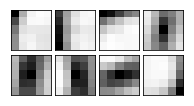

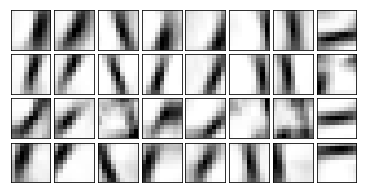

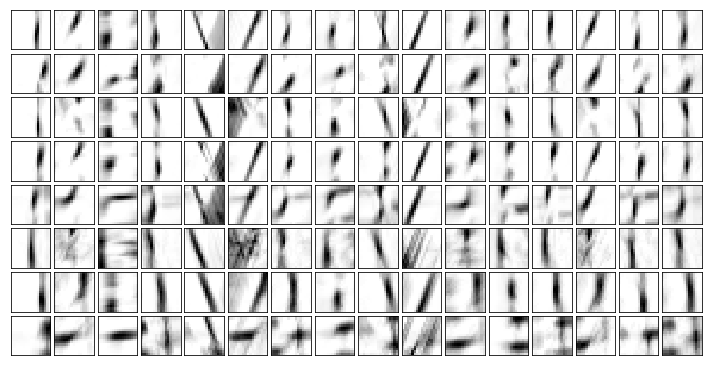

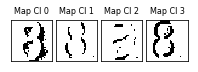

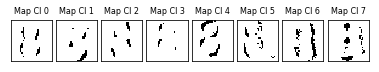

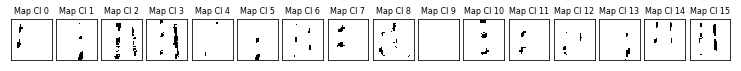

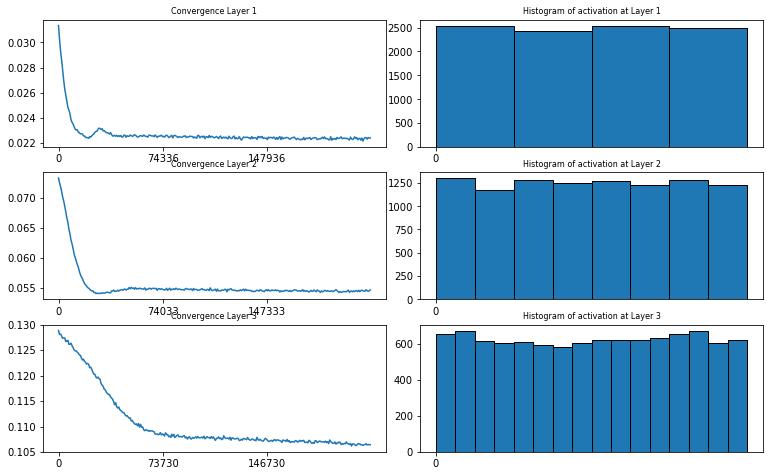

In [13]:
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
event_to_show = Event(ImageSize=(32, 32), ListPolarities=[-1, 1], OutOnePolarity=False)
event_to_show.LoadFromMat("../Data/ExtractedStabilized.mat", image_number=22)
Net.RunNetwork(event_to_show, NbClusterList=ClusterLayer)
mapL1 = GenerateAM(Net.Layers[0].output, ClusterLayer[0])
DisplayAM(mapL1, scale=2)
mapL2 = GenerateAM(Net.Layers[1].output, ClusterLayer[1])
DisplayAM(mapL2, scale=2)
mapL3 = GenerateAM(Net.Layers[2].output, ClusterLayer[2])
DisplayAM(mapL3, scale=2)

DisplayConvergence(ClusterLayer, to_display=["error", "histo"])